In [1]:
import skimage
import sklearn.feature_extraction
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import time
from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision

from torch.optim import lr_scheduler

%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
from fastai.layers import PixelShuffle_ICNR
from skimage.transform import rotate

In [44]:
writer = SummaryWriter('runs/rcan/64-128-wt_red')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
dir = '/workspace/data/Dhruv/pytorch/SuperResolution/Data'
train_images = np.zeros((800*4, 128, 128, 3))
i = 0
for f in os.listdir(dir + '/' + 'Train'):
    if(f.endswith(".png")):
        train_images[i] = (skimage.transform.resize(
            io.imread(dir + '/Train/' + f),(128, 128), mode ='constant'))
        train_images[i+1] = rotate(train_images[i], angle=90)
        train_images[i+2] = rotate(train_images[i], angle=180)
        train_images[i+3] = rotate(train_images[i], angle=270)
        i += 4     

In [ ]:
dir = '/workspace/data/Dhruv/pytorch/SuperResolution/Flickr2K'
train_images1 = np.zeros((2400, 512, 512, 3))
test_images1 = np.zeros((250, 512, 512, 3))
i = 0
for f in os.listdir(dir):
    if(f.endswith(".png")):
        if(i<2400):
            train_images1[i] = (skimage.transform.resize(
                skimage.io.imread(dir + '/' + f),(512,512), mode ='constant'))
            i += 1
        elif(i>=2400):
            test_images1[i-2400] = (skimage.transform.resize(
            skimage.io.imread(dir + '/' + f),(512,512), mode ='constant'))
            i += 1

In [ ]:
# Function to extract 64x64 patches from the images. 20 patches from each image.
def patchExtract(images, patch_size=(128, 128), max_patches=2):
    pe = sklearn.feature_extraction.image.PatchExtractor(patch_size=patch_size, max_patches = max_patches)
    pe_fit = pe.fit(images)
    pe_trans = pe.transform(images)
    return pe_trans

In [5]:
dir = '/workspace/data/Dhruv/pytorch/SuperResolution/Data'
test_images = np.zeros((100*4, 128, 128, 3))
i = 0
for f in os.listdir(dir + '/' + 'Validation'):
    if(f.endswith(".png")):
        test_images[i] = (skimage.transform.resize(
            io.imread(dir + '/Validation/' + f),(128, 128), mode ='constant'))
        test_images[i+1] = rotate(test_images[i], angle=90)
        test_images[i+2] = rotate(test_images[i], angle=180)
        test_images[i+3] = rotate(test_images[i], angle=270)
        i += 4

In [6]:
#train_images = np.concatenate((train_images, train_images1), axis=0)
#test_images = np.concatenate((test_images, test_images1), axis=0)
#train_images = patchExtract(train_images)
#test_images = patchExtract(test_images)
np.random.shuffle(train_images)
np.random.shuffle(test_images)

In [7]:
print(train_images.shape)
print(test_images.shape)

(3200, 128, 128, 3)
(400, 128, 128, 3)


In [2]:
def bicubicDownsample(images, scale_factor=0.5):
    out = torch.nn.functional.interpolate(images, scale_factor=scale_factor, mode='bicubic', align_corners=True)
    return out

In [10]:
y_tr = torch.from_numpy(train_images).permute(0,3,1,2)
y_tr = y_tr.float()
y_te = torch.from_numpy(test_images).permute(0,3,1,2)
y_te = y_te.float()

In [11]:
del train_images
del test_images

In [12]:
x_tr = bicubicDownsample(y_tr)
x_tr = x_tr.float()
x_te = bicubicDownsample(y_te)
x_te = x_te.float()

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [13]:
y_tr = y_tr.contiguous()
y_te = y_te.contiguous()
print(x_tr.is_contiguous())
print(x_te.is_contiguous())
print(y_tr.is_contiguous())
print(y_te.is_contiguous())

True
True
True
True


In [4]:
normalize = transforms.Normalize(mean=[0.4438008788229047, 0.43282444892005567, 0.39990855960960575],
                                     std=[0.26915865140736284, 0.25496531678120016, 0.2794830545396813])

In [15]:
# Creating custom training dataset
class TrainDataset(Dataset):
    def __init__(self, transform=None):
        self.x = x_tr
        self.y = y_tr
        self.n_samples = self.x.shape[0]
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.x[index]), self.transform(self.y[index])
        else:
            return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
# Creating custom testing dataset
class TestDataset(Dataset):
    def __init__(self, transform=None):
        self.x = x_te
        self.y = y_te
        self.n_samples = self.x.shape[0]
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.x[index]), self.transform(self.y[index])
        else:
            return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [16]:
batch_size = 4

In [17]:
train_dataset = TrainDataset(transform=normalize)
test_dataset = TestDataset(transform=normalize)

# Implementing train loader to split the data into batches
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True, # data reshuffled at every epoch
                          num_workers=2) # Use several subprocesses to load the data

# Implementing train loader to split the data into batches
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True, # data reshuffled at every epoch
                          num_workers=2) # Use several subprocesses to load the data

In [18]:
EPOCHS = 100
n_samples = len(train_dataset)
n_iterations = math.ceil(n_samples/batch_size)

## Creating Model

In [5]:
## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
        #torch.nn.init.kaiming_uniform_(self.conv_du[0].weight, nonlinearity='relu')
        #torch.nn.init.kaiming_uniform_(self.conv_du[2].weight, nonlinearity='relu')

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y
    
## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(self, n_feat, kernel_size=3, reduction=16,bias=False, bn=False, act=nn.ReLU(True), res_scale=1):
        super().__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size, bias=bias, padding=1))
            if bn: modules_body.append(nn.InstanceNorm2d(n_feat, affine=True))
            if i == 0: modules_body.append(act)
        '''
        torch.nn.init.kaiming_uniform_(modules_body[0].weight, nonlinearity='relu')
        if(bn==True):
            torch.nn.init.kaiming_uniform_(modules_body[3].weight, nonlinearity='relu')
        else:
            torch.nn.init.kaiming_uniform_(modules_body[2].weight, nonlinearity='relu')
        '''
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        res += x
        return res
    
## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, n_feat, n_resblocks, inorm, kernel_size=3, reduction=16, act=nn.ReLU(True), res_scale=1):
        super().__init__()
        modules_body = []
        modules_body = [
            RCAB(
                n_feat, kernel_size, reduction, bias=True, bn=inorm, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size, padding=1))
        #torch.nn.init.kaiming_uniform_(modules_body[-1].weight, nonlinearity='relu')
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

class DecoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, in_channels*2, kernel_size=1, stride=1, bias=True),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True))
        self.RG1 = ResidualGroup(n_feat=in_channels, n_resblocks=5, inorm=True)
        self.reduce_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        self.RG2 = ResidualGroup(n_feat=out_channels, n_resblocks=5, inorm=True)
        torch.nn.init.kaiming_uniform_(self.upsample[0].weight, nonlinearity='relu')
        torch.nn.init.kaiming_uniform_(self.reduce_channels.weight, nonlinearity='relu') 
            
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = torch.cat((x2,x1), dim=1)
        x = self.RG1(x)
        x = self.reduce_channels(x)
        x = self.RG2(x)
        return x
    
    
class DecoderLayerNoReduce(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, in_channels*2, kernel_size=1, stride=1, bias=True),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True)) 
        self.RG1 = ResidualGroup(n_feat=in_channels, n_resblocks=10, inorm=True)
        torch.nn.init.kaiming_uniform_(self.upsample[0].weight, nonlinearity='relu')
            
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = torch.cat((x2,x1), dim=1)
        x = self.RG1(x)
        return x


class FinalDecoderLayer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_resgroups = 5
        modules_body = [
            ResidualGroup(
                n_feat=in_channels, n_resblocks=10, inorm=False) \
            for _ in range(n_resgroups)]
        modules_body.append(nn.Conv2d(64, 64, kernel_size=7, padding=3))
        torch.nn.init.kaiming_uniform_(modules_body[-1].weight, nonlinearity='relu')
        self.body=nn.Sequential(*modules_body)
            
    def forward(self, x):
        res = self.body(x)
        res += x
        return res
    
class Upsampler(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, in_channels*4, kernel_size=1, stride=1, bias=True),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True))
        torch.nn.init.kaiming_uniform_(self.upsample[0].weight, nonlinearity='relu')
        
    def forward(self, x):
        x = self.upsample(x)
        return x
    
class ResUNet(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.base_model = torchvision.models.resnet34(pretrained=True, progress=False)
        self.base_layers = list(self.base_model.children())
        
        # Encoder path
        self.in_layer = nn.Sequential(*self.base_layers[0:3])
        self.layer1 = nn.Sequential(*self.base_layers[4])
        self.layer2 = nn.Sequential(*self.base_layers[5])
        self.layer3 = nn.Sequential(*self.base_layers[6])
        
        # Cross path
        self.cross = nn.Conv2d(3, 32 ,kernel_size=1, bias=True)
        
        # Decoder path
        self.up1 = DecoderLayer(256, 128)
        self.up2 = DecoderLayer(128, 64)
        self.up3 = DecoderLayerNoReduce(64)
        self.up4 = FinalDecoderLayer(64)
        self.upsample = Upsampler(64)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=9, padding=4)
        torch.nn.init.kaiming_uniform_(self.cross.weight, nonlinearity='relu')
        torch.nn.init.kaiming_uniform_(self.final_conv.weight, nonlinearity='relu')
      
        
    def forward(self, x):
        #Encoder path
        x_inp = x
        x_in = self.in_layer(x)
        x_l1 = self.layer1(x_in)
        x_l2 = self.layer2(x_l1)
        x_l3 = self.layer3(x_l2)
        
        # Decoder path
        x = self.up1(x_l3, x_l2)
        x = self.up2(x, x_l1)
        x_inp = self.cross(x_inp)
        x = self.up3(x, x_inp) 
        x = self.up4(x)
        x = self.upsample(x)
        x = self.final_conv(x) 
        return x

## Creating Loss Function (Perceptual Loss)

In [41]:
class VGGPerceptualLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        model = torchvision.models.vgg16(pretrained=True, progress=False)
        features = model.features
        self.relu1_2 = nn.Sequential()
        self.relu2_2 = nn.Sequential()
        self.relu3_3 = nn.Sequential()
        self.relu4_3 = nn.Sequential()
        for i in range(4):
            self.relu1_2.add_module(name="relu1_2_"+str(i+1), module=features[i])
        for i in range(4, 9):
            self.relu2_2.add_module(name="relu2_2_"+str(i-3), module=features[i])
        for i in range(9, 16):
            self.relu3_3.add_module(name="relu3_3_"+str(i-8), module=features[i])
        for i in range(16, 23):
            self.relu4_3.add_module(name="relu4_3_"+str(i-15), module=features[i])      
        # Setting requires_grad=False to fix the perceptual loss model parameters 
        for param in self.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        out_relu1_2 = self.relu1_2(x)
        out_relu2_2 = self.relu2_2(out_relu1_2)
        out_relu3_3 = self.relu3_3(out_relu2_2)
        out_relu4_3 = self.relu4_3(out_relu3_3)
        return out_relu1_2, out_relu2_2, out_relu3_3, out_relu4_3
    
# Function to calculate Gram matrix
def gram(x):
    (N, C, H, W) = x.shape
    psy = x.view(N, C, H*W)
    psy_T = psy.transpose(1, 2)
    G = torch.bmm(psy, psy_T) / (C*H*W)  # Should we divide by N here? Or does batch matric multiplication do that on it's own? 
    return G

def TVR(x, TV_WEIGHT=1e-6):
    diff_i = torch.sum(torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]))
    diff_j = torch.sum(torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]))
    tv_loss = TV_WEIGHT*(diff_i + diff_j)
    return tv_loss

In [42]:
VGGLoss = VGGPerceptualLoss().to(device)

In [43]:
def PerceptualLoss(x, y, STYLE_WEIGHT=1e-4, CONTENT_WEIGHT=1e-1, PIXEL_WEIGHT=1):
    
    x_features = VGGLoss(x)
    y_features = VGGLoss(y)
    
    # Calculating per-pixel loss
    C = y.shape[1]
    H = y.shape[2]
    W = y.shape[3]
    pixel_loss =  F.mse_loss(x, y, reduction='sum') / (C*H*W)
    #print("pixel loss= ",pixel_loss)
    
    # Calculating Total variation regularization value
    tvr_loss = TVR(x)
    #print("tvr loss= ", tvr_loss)
    
    # Calculating content loss
    #weights = [0.25, 0.25, 0.25]
    content_loss = 0.0
    for i in range(2,4):
        C = y_features[i].shape[1]
        H = y_features[i].shape[2]
        W = y_features[i].shape[3]
        content_loss += (F.l1_loss(y_features[i], x_features[i], reduction='sum') / (C*H*W))
        #print('c',content_loss)
    #print("content loss= ", content_loss)
    '''
    # Calculating content loss
    C = y_features[2].shape[1]
    H = y_features[2].shape[2]
    W = y_features[2].shape[3]
    content_loss = F.l1_loss(x_features[2], y_features[2], reduction='sum') / (C*H*W)
    #print(content_loss)
    '''
    # Calculating Style loss
    style_loss = 0.0
    for i in range(4):
        C = y_features[i].shape[1]
        H = y_features[i].shape[2]
        W = y_features[i].shape[3]
        style_loss += F.l1_loss(gram(x_features[i]), gram(y_features[i]), reduction='sum')
        #print('s ',style_loss)
    #print("style loss= ", style_loss)
    total_loss = STYLE_WEIGHT*style_loss + CONTENT_WEIGHT*content_loss + PIXEL_WEIGHT*pixel_loss + tvr_loss
    return total_loss

In [24]:
'''
example = iter(train_loader)
example_data, example_target = example.next()
example_data = F.interpolate(example_data, scale_factor=4, mode='bicubic', align_corners=False)
loss = PerceptualLoss(example_data.to(device), example_target.to(device))
del example
del example_data
del example_target
'''

## Training Loop

In [21]:
# Implementing checkpoints
def save_checkpoint_best(epoch, model):
    print("Saving best model")
    PATH = "/workspace/data/Dhruv/pytorch/SuperResolution/BestModel/best_model_"+str(epoch)+".pt"
    torch.save(model.state_dict(), PATH)

def save_checkpoint(epoch, model, optimizer, loss):  # Saving model in a way so we can load and start training again
    PATH = "/workspace/data/Dhruv/pytorch/SuperResolution/Models/model_"+str(epoch)+".pt"
    print("Saving model")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': loss,
            }, PATH)

In [46]:
#del model
tr_loss_log = []
val_loss_log = []
model = ResUNet(3).to(device)

In [25]:
for name, layer in model._modules.items():
    if name in ['in_layer', 'layer1', 'layer2', 'layer3', 'layer4']:
        for param in layer.parameters():
            param.requires_grad = False
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [47]:
encoder=[]
decoder=[]
for name, layer in model._modules.items():
    if name in ['in_layer', 'layer1', 'layer2', 'layer3']:
        print(name)
        for param in layer.parameters():
            param.requires_grad = True
            encoder.append(param)
    elif name in ['cross', 'up1', 'up2', 'up3', 'up4', 'upsample', 'final_conv']:
        print(name)
        for param in layer.parameters():
            param.requires_grad = True
            decoder.append(param)

optimizer = torch.optim.Adam([
                {'params': decoder},
                {'params': encoder, 'lr': 0.00005}
            ], lr=0.0001)

criterion = nn.L1Loss(reduction='sum')

in_layer
layer1
layer2
layer3
cross
up1
up2
up3
up4
upsample
final_conv


In [ ]:
for param in model.parameters():
    print(param.requires_grad)

In [24]:
example = iter(train_loader)
example_data, example_target = example.next()
writer.add_graph(model, example_data.to(device))
writer.close()
del example
del example_data
del example_target

/opt/conda/lib/python3.6/site-packages/torch/jit/__init__.py:1119: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 11940 element(s) (out of 196608) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.00012922286987304688 (-4.397583961486816 vs. -4.3977131843566895), which occurred at index (0, 2, 58, 92).
  check_tolerance, strict, _force_outplace, True, _module_class)


In [48]:
# Training Loop
def train_model():
    least_val_loss = math.inf
    C = 3
    H = 128.0
    W = 128.0

    for epoch in range(EPOCHS):
        
        if((epoch+1)%20 == 0 and epoch!=99):
            print('Learning Rates reduced')
            print('New Learning Rates')
            for g in optimizer.param_groups:
                g['lr'] = g['lr']/2
                print(g['lr'])
        
        beg_time = time.time() #To calculate time taken for each epoch

        train_loss = 0.0
        val_loss = 0.0

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            # Will run for 1000 iterations per epoch
            optimizer.zero_grad()
            # Forward pass
            out = model(x)
            #Calculating loss
            loss = criterion(out, y)/(C*H*W)
            # Backward pass
            loss.backward()
            # Update gradients
            optimizer.step()
            # Get training loss
            train_loss += loss.item()
        tr_loss_log.append(train_loss)

        model.eval()
        with torch.no_grad():
            for i, (x, y) in enumerate(test_loader):
                x = x.to(device)
                y = y.to(device)
                out = model(x)
                #Calculating loss
                loss = criterion(out, y)/(C*H*W)
                # Get validation loss
                val_loss += loss.item()
            val_loss_log.append(val_loss)
        model.train()


        # Saving checkpoints
        #save_checkpoint(epoch+1, model, optimizer, val_loss)
        if(val_loss < least_val_loss):
            save_checkpoint_best(epoch+1, model)
            least_val_loss = val_loss

        end_time = time.time()
        print('Epoch: {:.0f}/{:.0f}, Time: {:.0f}m {:.0f}s, Train_Loss: {:.4f}, Val_loss: {:.4f}'.format(
              epoch+1, EPOCHS, (end_time-beg_time)//60, (end_time-beg_time)%60, train_loss, val_loss))
        writer.add_scalar('Training_loss', train_loss, epoch+1)
        writer.add_scalar('Validation_loss', val_loss, epoch+1)
        writer.close()

In [50]:
train_model()

Saving best model
Epoch: 1/100, Time: 2m 45s, Train_Loss: 1245.5851, Val_loss: 55.0156
Saving best model
Epoch: 2/100, Time: 2m 46s, Train_Loss: 403.9085, Val_loss: 45.0584
Epoch: 3/100, Time: 2m 43s, Train_Loss: 347.8429, Val_loss: 45.4955
Saving best model
Epoch: 4/100, Time: 2m 46s, Train_Loss: 328.7250, Val_loss: 40.8592
Saving best model
Epoch: 5/100, Time: 2m 47s, Train_Loss: 318.1705, Val_loss: 39.8262
Saving best model
Epoch: 6/100, Time: 2m 46s, Train_Loss: 305.4254, Val_loss: 37.9256
Epoch: 7/100, Time: 2m 46s, Train_Loss: 297.5784, Val_loss: 39.9884
Saving best model
Epoch: 8/100, Time: 2m 45s, Train_Loss: 288.5546, Val_loss: 37.0212
Saving best model
Epoch: 9/100, Time: 2m 47s, Train_Loss: 287.6850, Val_loss: 36.3782
Saving best model
Epoch: 10/100, Time: 2m 46s, Train_Loss: 283.7914, Val_loss: 36.0218
Saving best model
Epoch: 11/100, Time: 2m 45s, Train_Loss: 275.7061, Val_loss: 35.5691
Epoch: 12/100, Time: 2m 46s, Train_Loss: 277.7896, Val_loss: 36.1484
Epoch: 13/100, Tim

In [49]:
%tensorboard --logdir=runs/rcan

In [43]:
# Saving the final model
PATH = "/workspace/data/Dhruv/pytorch/SuperResolution/FinalModel/rcan/64-128-small-try1.pt"
print("Saving final model")
torch.save(model.state_dict(), PATH)

Saving final model


In [ ]:
# Saving just model
PATH = "/workspace/data/Dhruv/pytorch/SuperResolution/JustModels/final_trained_model_inorm128.pt"
torch.save(model, PATH)

In [51]:
# Loading model
model = ResUNet(3).to(device)
model.load_state_dict(torch.load("/workspace/data/Dhruv/pytorch/SuperResolution/FinalModel/36433/model-128-256.pt"))

<All keys matched successfully>

In [ ]:
# To load the final model (fill in the final model epoch number)
loaded_final_model = ResUNet(3).to(device)
checkpoint = torch.load("/workspace/data/Dhruv/pytorch/SuperResolution/FinalModel/modified-res-dense-inorm-big128.pt")
loaded_final_model.load_state_dict(checkpoint)
#loaded_final_model.eval()
model = loaded_final_model
del loaded_final_model

In [6]:
# To load the best model (fill in the best model epoch number)
#del model
model = ResUNet(3).to(device)
model.load_state_dict(torch.load("/workspace/data/Dhruv/pytorch/SuperResolution/BestModel/best_model_29.pt")) #3

<All keys matched successfully>

In [ ]:
# Loading a model with desired epoch number
loaded_model = ResUNet(3).to(device)
checkpoint = torch.load("/workspace/data/Dhruv/pytorch/SuperResolution/Models/model_8.pt")
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()
model = loaded_model

## Inference

In [20]:
mean=[0.4438008788229047, 0.43282444892005567, 0.39990855960960575]
std=[0.26915865140736284, 0.25496531678120016, 0.2794830545396813]
def unorm(data):
    img =((data * std + mean)*255.0).clip(0, 255).astype("uint8")
    return img

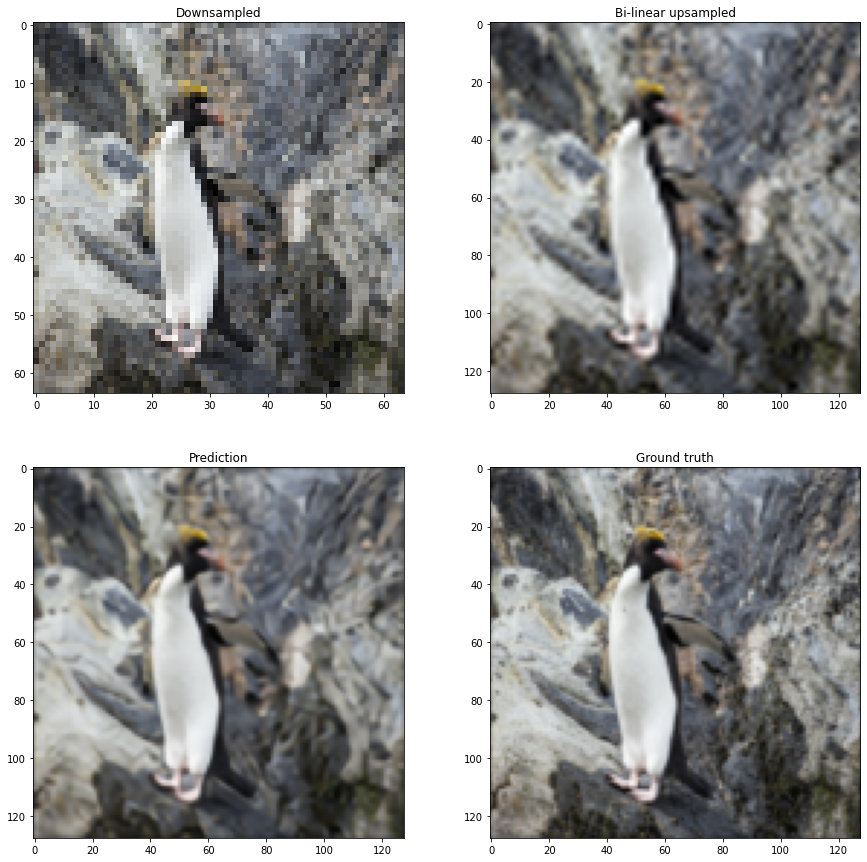

In [41]:
model.eval()
example = iter(test_loader)
example_data, example_target = example.next()

plt.figure(figsize=(15,15))
# Downsampled
plt.subplot(2,2,1)
plt.title('Downsampled')
down = example_data[0].permute(1,2,0).numpy()
plt.imshow(unorm(down))
# Bi-linear upsampled
out_1 = F.interpolate(example_data, scale_factor=2, mode='bicubic', align_corners=True)
plt.subplot(2,2,2)
plt.title('Bi-linear upsampled')
bi = out_1[0].permute(1,2,0).numpy()
plt.imshow(unorm(bi))
# Model prediction
out_2 = model(example_data.to(device))
plt.subplot(2,2,3)
plt.title('Prediction')
pred = out_2[0].cpu().detach().permute(1,2,0).numpy()
plt.imshow(unorm(pred))
# Ground truth
plt.subplot(2,2,4)
plt.title('Ground truth')
gt = example_target[0].permute(1,2,0).numpy()
plt.imshow(unorm(gt))

In [ ]:
model.eval()
model1.eval()
#example = iter(test_loader)
#example_data, example_target = example.next()

# old is only with 2 in perceptual, new is with 2 and 3 in perceptual

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
out_2 = model(example_data.to(device))
plt.title('Prediction model')
plt.imshow(out_2[15].cpu().detach().permute(1,2,0))

plt.subplot(1,2,2)
plt.title('Prediction model1')
out_2 = model1(example_data.to(device))
plt.imshow(out_2[15].cpu().detach().permute(1,2,0))

In [4]:
#from skimage.metrics import structural_similarity as ssim
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(256.0 / rmse)

def get_y(data):
    data = 255 * data # Now scale by 255
    data = data.astype(np.uint8)
    #y = _ycc(data[:,:,0], data[:,:,1], data[:,:,2])
    fin = skimage.color.convert_colorspace(data,'RGB','YCbCr')
    y = fin[:,:,0]
    #y = y.astype(np.uint8)
    return y

def calc_psnr(sr, hr, scale, rgb_range=256, dataset=None):
    if hr.nelement() == 1: return 0

    diff = (sr - hr) / rgb_range
    if dataset and dataset.dataset.benchmark:
        shave = scale
        if diff.size(1) > 1:
            gray_coeffs = [65.738, 129.057, 25.064]
            convert = diff.new_tensor(gray_coeffs).view(1, 3, 1, 1) / 256
            diff = diff.mul(convert).sum(dim=1)
    else:
        shave = scale + 6

    valid = diff[..., shave:-shave, shave:-shave]
    mse = valid.pow(2).mean()
    return -10 * math.log10(mse)

In [166]:
# Asked from Yulun
import skimage.color as sc
import numpy as np
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_ssim as ssim

def shave(image, border):
    image = image[border[0]:-border[0],
                  border[1]:-border[1], ...]
    
    return image


def calc_psnr(imGT, imSR, scale):
    if len(imGT.shape) > 2 and imGT.shape[2] > 1:
        imGT = sc.rgb2ycbcr(imGT)[..., 0]
    
    if len(imSR.shape) > 2 and imSR.shape[2] > 1:
        imSR = sc.rgb2ycbcr(imSR)[..., 0]
    
    imGT = shave(imGT, [scale, scale])
    imSR = shave(imSR, [scale, scale])
    
    imGT = imGT.astype(np.float32)/255.0
    imSR = imSR.astype(np.float32)/255.0
    cur_psnr = psnr(imGT, imSR)
    cur_ssim = ssim(imGT, imSR) # This is different from Matlab execution.
    
    return cur_psnr, cur_ssim

In [62]:
# copied from san
#from skimage.metrics import structural_similarity as ssim
def calc_psnr(sr, hr, scale, rgb_range, benchmark=False):
    diff = (sr - hr).data.div(rgb_range)
    shave = scale
    if diff.size(1) > 1:
        convert = diff.new(1, 3, 1, 1)
        convert[0, 0, 0, 0] = 65.738
        convert[0, 1, 0, 0] = 129.057
        convert[0, 2, 0, 0] = 25.064
        diff.mul_(convert).div_(256)
        diff = diff.sum(dim=1, keepdim=True)
    '''
    if benchmark:
        shave = scale
        if diff.size(1) > 1:
            convert = diff.new(1, 3, 1, 1)
            convert[0, 0, 0, 0] = 65.738
            convert[0, 1, 0, 0] = 129.057
            convert[0, 2, 0, 0] = 25.064
            diff.mul_(convert).div_(256)
            diff = diff.sum(dim=1, keepdim=True)
    else:
        shave = scale + 6
    '''
    shave = scale + 6
    valid = diff[:, :, shave:-shave, shave:-shave]
    mse = valid.pow(2).mean()

    return -10 * math.log10(mse)

In [63]:
def quantize(img):
    rgb_range = float(img.max()) - float(img.min())
    pixel_range = 255 / rgb_range
    return img.mul(pixel_range).clamp(0, 255).round().div(pixel_range)

In [64]:
# Find all values for set 5
import matplotlib
directory = '/workspace/data/Dhruv/pytorch/Set5'
#directory = '/workspace/data/Dhruv/pytorch/Set14/Set14'   # use and f!='comic.png' and f!='zebra.png' and f!='ppt3.png'
img=[]
names=[]
for f in os.listdir(directory):
    if(f.endswith('.png')):
        img.append(skimage.io.imread(directory+'/'+f))
        names.append(f)
mypsnr=0
myssim=0
for i in range(len(img)):
    img_in = img[i].astype(np.float32)/255.0
    img_in = np.expand_dims(img_in, 0)
    img_in = torch.from_numpy(img_in).permute(0,3,1,2)
    img_down = bicubicDownsample(img_in)
    out = torch.nn.functional.interpolate(img_down, scale_factor=2, mode='bicubic', align_corners=True)
    #out_img = out[0].cpu().detach().permute(1,2,0).numpy()
    #img_gt = (img[i]*255.0).astype(np.uint8).clip(0,255)
    #out_img = (out_img*255.0).astype(np.uint8).clip(0,255)
    print(names[i])
    psnr1 = calc_psnr(quantize(img_in[0]), quantize(out), 2, float(quantize(img_in).max()) - float(quantize(img_in).min()))
    mypsnr+=psnr1
    #myssim+=ssim1

print(mypsnr/len(img))
print(myssim/len(img))    

woman.png
butterfly.png
bird.png
baby.png
head.png
33.93878254847985
0.0


In [99]:
# For comparision
import matplotlib  
directory = '/workspace/data/Dhruv/pytorch'
img = img.astype(np.float32)/255.0
print(img.shape)

#img_in = (img - mean)/std
img_in = skimage.io.imread(directory)
print(img_in.shape)
img_in = img_in.astype(np.float32)/255.0
img_in = np.expand_dims(img_in, 0)
img_down = torch.from_numpy(img_in).permute(0,3,1,2)
#img_down = bicubicDownsample(img_in)
#out = model(img_down.to(device))
out = torch.nn.functional.interpolate(img_down, scale_factor=2, mode='bicubic', align_corners=True)
out_img = out[0].cpu().detach().permute(1,2,0).numpy()
#out_img = out_img * std + mean
'''
plt.imshow(get_y(out_img))
plt.show()
plt.imshow(get_y(img))
plt.show()
#print(ssim(get_y(img).astype(np.uint8), get_y(out_img).astype(np.uint8), data_range=(int(np.max(get_y(out_img)))-(int(np.min(get_y(out_img)))))
print(PSNR(get_y(out_img), get_y(img), 2))
#print(calc_psnr(out[0].cpu().detach(), img_in.cpu().detach(), 2))
#matplotlib.image.imsave('compare/my_butterfly_4x.png', np.clip(out_img,0,1))
'''

(2040, 1356, 3)
(1020, 678, 3)


"\nplt.imshow(get_y(out_img))\nplt.show()\nplt.imshow(get_y(img))\nplt.show()\n#print(ssim(get_y(img).astype(np.uint8), get_y(out_img).astype(np.uint8), data_range=(int(np.max(get_y(out_img)))-(int(np.min(get_y(out_img)))))\nprint(PSNR(get_y(out_img), get_y(img), 2))\n#print(calc_psnr(out[0].cpu().detach(), img_in.cpu().detach(), 2))\n#matplotlib.image.imsave('compare/my_butterfly_4x.png', np.clip(out_img,0,1))\n"

In [100]:
img = (img*255.0).astype(np.uint8).clip(0,255)
out_img = (out_img*255.0).astype(np.uint8).clip(0,255)

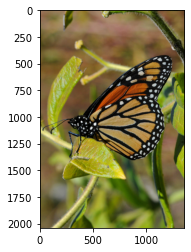

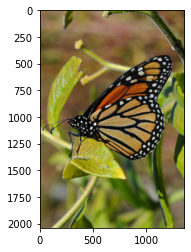

In [101]:
plt.imshow(img)
plt.show()
plt.imshow(out_img)
plt.show()

In [102]:
psnr,ssim = calc_psnr(img, out_img, 2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


In [153]:
psnr

32.294655703023864

In [36]:
def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


directory = 'compare/butterfly.png'
image = skimage.io.imread(directory)
#img = img/255.0
image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)

y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y).to(device)
y = y.unsqueeze(0).unsqueeze(0)

In [37]:
y.shape

torch.Size([1, 1, 256, 256])

In [41]:
np.ma

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


## Visualizing activations

In [38]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


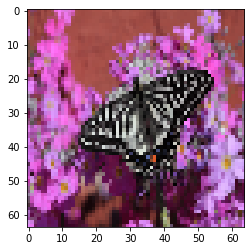

In [40]:
data, _ = test_dataset[190]
plt.imshow(data.permute(1,2,0))

In [42]:
# Find activations for all the layers of the model
for name, layer in model._modules.items():
  layer.register_forward_hook(get_activation(name))
data, _ = test_dataset[190]
data.unsqueeze_(0)
output = model(data.to(device))

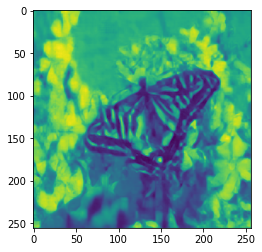

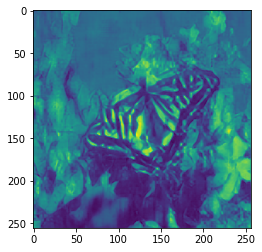

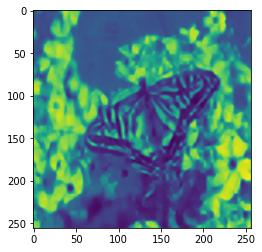

In [55]:
act = activation['final_conv'].squeeze().cpu()
for idx in range(act.size(0)):
    plt.imshow(act[idx])
    plt.show()

In [68]:
model.upconv4.weight.grad

tensor([[[[-2.5054e-05,  4.2236e-05,  6.5525e-05,  ..., -4.3422e-05,
           -4.8266e-05,  1.8864e-05],
          [-7.6594e-05, -5.0875e-05, -4.4871e-05,  ...,  2.5969e-05,
           -2.3034e-05,  5.7482e-05],
          [-1.6504e-06,  3.1123e-05,  5.3025e-07,  ..., -3.8598e-05,
           -8.1801e-06, -3.9697e-05],
          ...,
          [-3.0856e-05, -1.8377e-05,  7.6936e-06,  ..., -7.3867e-05,
           -6.7357e-07, -2.6048e-05],
          [ 9.8162e-06,  5.3328e-05,  6.0214e-05,  ...,  2.1922e-06,
           -2.0340e-05,  3.5540e-06],
          [-4.4381e-06,  1.2134e-04,  1.0104e-05,  ...,  1.8378e-05,
            2.4714e-05, -6.3497e-06]],

         [[-1.9035e-04, -1.2809e-04, -1.5692e-04,  ..., -2.3368e-04,
           -1.7319e-04, -2.5250e-04],
          [-5.8263e-05, -1.6180e-04, -1.0581e-04,  ..., -4.7342e-05,
           -1.4791e-04, -3.5632e-05],
          [-2.5940e-04, -2.0370e-04, -3.6222e-04,  ..., -4.1088e-04,
           -2.6110e-04, -2.9870e-04],
          ...,
     